# Prediction of the movie revenue

### This dataset *movies.csv* can be downloaded from Google drive: https://drive.google.com/drive/folders/1MwFoUvUp2St0Sjq0I9dlNIl_BXkw3fZU

In [44]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

    
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_score

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 24)

# Reading the Data

In [45]:
df = pd.read_csv('data/movies_new.csv')
#df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
print(df.dtypes)

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
dtype: object


In [46]:
#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['genres'] = df['genres'].astype(str)
df['production_companies'] = df['production_companies'].astype(str)
df['cast'] = df['cast'].astype(str)
df['keywords'] = df['keywords'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
# df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['keywords'] = df['keywords'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))
# df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x))

Some adjustments

In [47]:
#Extra adjustments for the points discovered later during the process

#replace FRF budget by USD
df.loc[df['id'] == 10656, ['budget']] = 25974
print(df.loc[df['id'] == 10656, ['title']])

#wrong revenue
df.loc[df['id'] == 9838, ['revenue']] = 15057465
print(df.loc[df['id'] == 9838, ['title']])

       title
2134  Subway
                     title
1242  King Solomon's Mines


In [49]:
# Analize release date
# We see that there is a strong tendency of grouth movies produced every year
df['year'] = df['release_date'].dt.year
df['year_month'] = pd.to_datetime(df['release_date']).dt.to_period('M')

### Choosing time period

In [50]:
#Slicing our data 

df = df[(df['year']>=2000) & (df['year']<2017)]

print(df.shape)

(3030, 16)


In [51]:
df.head(5)

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords,year,year_month
3,121173,Voracious,11178,34659.00,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.08,8.00,1.00,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ...",2012,2012-09
5,110428,Camille Claudel 1915,3512454,115860.00,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
6,110428,Camille Claudel 1915,3512454,115860.00,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
7,110428,Camille Claudel 1915,3512454,115860.00,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
8,110428,Camille Claudel 1915,3512454,115860.00,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03


Kepping only movies which were produced in USA as the budget might be marked in US although in reality its not 

In [54]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]

print(df.shape)



Number of production countries:  68
(2450, 16)


# Choosing the columns

In [55]:
X = df[['budget', 'year', 'genres', 'production_companies', 'vote_average', 'popularity', 'revenue',  'vote_count', 
        'belongs_to_collection', 'cast']]
# y = df['revenue']
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# Feature engineering

### Budget

(array([1.436e+03, 5.540e+02, 2.150e+02, 1.440e+02, 5.200e+01, 3.100e+01,
        1.400e+01, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([7.000000e+03, 3.800630e+07, 7.600560e+07, 1.140049e+08,
        1.520042e+08, 1.900035e+08, 2.280028e+08, 2.660021e+08,
        3.040014e+08, 3.420007e+08, 3.800000e+08]),
 <a list of 10 Patch objects>)

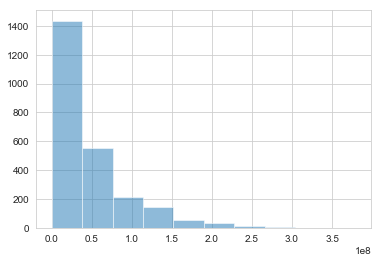

In [56]:
#plt.hist(X['budget'], alpha=0.5)
#print(X.groupby('budget')['id'].count())

#X['budget'] = np.log(X['budget'])
plt.hist(X['budget'], alpha=0.5)

Removing outliers

In [57]:
# print(X['budget'].describe())

# mean_a = np.mean(X['budget'])
# std_a = np.std(X['budget'])

# X = X[(X['budget']>mean_a-3*std_a)&(X['budget']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['budget'].describe())

# plt.figure()
# plt.hist(X['budget'])
# plt.show

### Revenue

(array([2.017e+03, 2.550e+02, 8.200e+01, 4.900e+01, 3.100e+01, 1.000e+01,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([1.40400000e+03, 2.06823626e+08, 4.13645848e+08, 6.20468070e+08,
        8.27290292e+08, 1.03411251e+09, 1.24093474e+09, 1.44775696e+09,
        1.65457918e+09, 1.86140140e+09, 2.06822362e+09]),
 <a list of 10 Patch objects>)

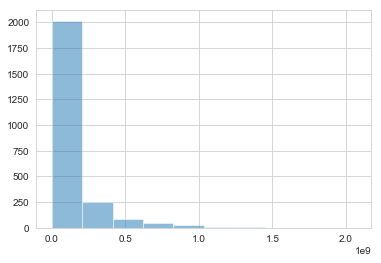

In [58]:
#plt.hist(X['revenue'])

#X['revenue'] = np.log(X['revenue'])
plt.hist(X['revenue'], alpha=0.5)

Removing outliers

In [59]:
# print(X['revenue'].describe())

# mean_a = np.mean(X['revenue'])
# std_a = np.std(X['revenue'])

# X = X[(X['revenue']>mean_a-3*std_a)&(X['revenue']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['revenue'].describe())

# plt.figure()
# plt.hist(X['revenue'])
# plt.show

### Vote count

(array([773., 480., 287., 192., 140., 116.,  71.,  58.,  61.,  37.,  35.,
         30.,  20.,  16.,  18.,  12.,  21.,  13.,   7.,   6.,  11.,   8.,
          4.,   8.,   3.,   5.,   2.,   3.,   1.,   2.,   0.,   4.,   1.,
          0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.000000e+00, 2.844400e+02, 5.658800e+02, 8.473200e+02,
        1.128760e+03, 1.410200e+03, 1.691640e+03, 1.973080e+03,
        2.254520e+03, 2.535960e+03, 2.817400e+03, 3.098840e+03,
        3.380280e+03, 3.661720e+03, 3.943160e+03, 4.224600e+03,
        4.506040e+03, 4.787480e+03, 5.068920e+03, 5.350360e+03,
        5.631800e+03, 5.913240e+03, 6.194680e+03, 6.476120e+03,
        6.757560e+03, 7.039000e+03, 7.320440e+03, 7.601880e+03,
        7.883320e+03, 8.164760e+03, 8.446200e+03, 8.727640e+03,
        9.009080e+03, 9.290520e+03, 9.571960e+03, 9.853400e+03,
        1.013484e+04, 1.041628e+04, 1.069772e+04, 1.097916e+04,
        1.126060e+

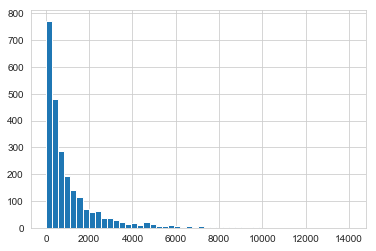

In [60]:
plt.hist(X['vote_count'], bins=50)

### Vote average

(array([  1.,   0.,   0.,   0.,   1.,   0.,   4.,   1.,   0.,   1.,   2.,
          3.,   2.,   5.,   5.,  11.,   5.,   5.,  27.,  17.,  19.,  24.,
         35.,  37.,  42., 118.,  68.,  85.,  95.,  99., 118., 248., 121.,
        117., 107., 105., 118., 231.,  95.,  75.,  86.,  46.,  55., 106.,
         26.,  23.,  24.,  10.,  16.,  11.]),
 array([2.3  , 2.416, 2.532, 2.648, 2.764, 2.88 , 2.996, 3.112, 3.228,
        3.344, 3.46 , 3.576, 3.692, 3.808, 3.924, 4.04 , 4.156, 4.272,
        4.388, 4.504, 4.62 , 4.736, 4.852, 4.968, 5.084, 5.2  , 5.316,
        5.432, 5.548, 5.664, 5.78 , 5.896, 6.012, 6.128, 6.244, 6.36 ,
        6.476, 6.592, 6.708, 6.824, 6.94 , 7.056, 7.172, 7.288, 7.404,
        7.52 , 7.636, 7.752, 7.868, 7.984, 8.1  ]),
 <a list of 50 Patch objects>)

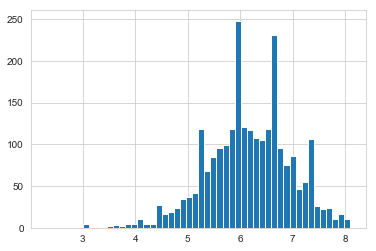

In [61]:
plt.hist(X['vote_average'], bins=50)

Removing outliers

count   2450.00
mean       6.16
std        0.81
min        2.30
25%        5.62
50%        6.20
75%        6.70
max        8.10
Name: vote_average, dtype: float64
After removing outliers:
count   2436.00
mean       6.17
std        0.78
min        3.80
25%        5.70
50%        6.20
75%        6.70
max        8.10
Name: vote_average, dtype: float64


<function matplotlib.pyplot.show(*args, **kw)>

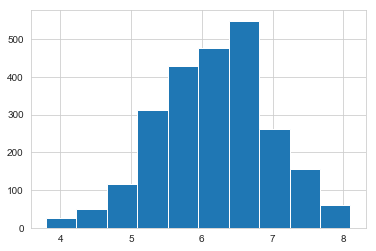

In [62]:
print(X['vote_average'].describe())

mean_a = np.mean(X['vote_average'])
std_a = np.std(X['vote_average'])

X = X[(X['vote_average']>mean_a-3*std_a)&(X['vote_average']<mean_a+3*std_a)]

print('After removing outliers:')
print(X['vote_average'].describe())

plt.figure()
plt.hist(X['vote_average'])
plt.show

### Popularity

(array([ 190., 1027.,  789.,  261.,   82.,   38.,   27.,   12.,    6.,
           4.]),
 array([ 0.262437 ,  4.9688598,  9.6752826, 14.3817054, 19.0881282,
        23.794551 , 28.5009738, 33.2073966, 37.9138194, 42.6202422,
        47.326665 ]),
 <a list of 10 Patch objects>)

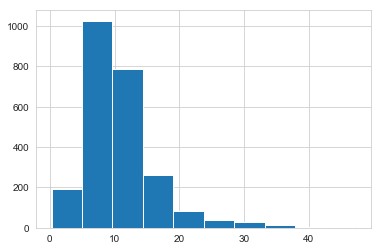

In [63]:
plt.hist(X['popularity'])

Removing outliers

count   2436.00
mean      10.76
std        5.71
min        0.26
25%        7.22
50%        9.69
75%       12.92
max       47.33
Name: popularity, dtype: float64
After removing outliers:
count   2383.00
mean      10.25
std        4.57
min        0.26
25%        7.15
50%        9.58
75%       12.69
max       27.76
Name: popularity, dtype: float64


<function matplotlib.pyplot.show(*args, **kw)>

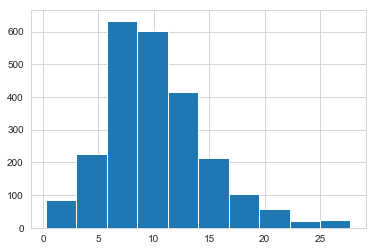

In [64]:

print(X['popularity'].describe())

mean_a = np.mean(X['popularity'])
std_a = np.std(X['popularity'])

X = X[(X['popularity']>mean_a-3*std_a)&(X['popularity']<mean_a+3*std_a)]

print('After removing outliers:')
print(X['popularity'].describe())

plt.figure()
plt.hist(X['popularity'])
plt.show

### Genres

In [65]:
# del X['genres']

In [66]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

# Create column for every genre and assigh 1 or 0
for genre in g_name:
    idx = index_extractor(X, 'genres', genre)
    c = list_creator(X, idx)
    genre_col = pd.Series(c)    
    X = X.assign(genre_col=genre_col.values)
    X.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)
del X['genres']
  


### Belongs_to_collection

In [67]:
X['collection'] = [0 if col == '0' else 1 for col in X['belongs_to_collection']]
del X['belongs_to_collection']

In [68]:
# index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df[field]) if (type(item) != int) if value in item['name']]
# list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

# #Extracting list of collections
# l=[]
# for i, item in enumerate(X['belongs_to_collection']):
#     if type(item) != int:
#         #print(type(item))
#         #item = ast.literal_eval(item)
#         #print(type(item))
#         l.append(item['name'])
# p_name, p_count = np.unique(np.array(l), return_counts=True)

# prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
# prod = list(prod)
# prod = sorted(prod, key = lambda x: x[1], reverse = True)
# print('Number of collections: ', len(prod))
    
# #100 collections with the most number of movies in it
# p_name = []
# p_count = []
# for i in range(50):
#     p_name.append(prod[i][0])
#     p_count.append(prod[i][1])

In [69]:
# # Create column for every collection and assigh 1 or 0
# for prod in p_name:
#     idx = index_extractor(X, 'belongs_to_collection', prod)
#     c = list_creator(X, idx)
#     prod_col = pd.Series(c)    
#     X = X.assign(prod_col=prod_col.values)
#     X.rename(columns={'prod_col':'{0}'.format(prod)}, inplace=True)
# del X['belongs_to_collection']

### Production Companies

In [70]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['production_companies']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production companies: ', len(prod))
    
#100 companies which produced the hihest number of movies
p_name = []
p_count = []
for i in range(100):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])

Number of production companies:  2855


In [71]:
# Create column for every production companie and assigh 1 or 0
for prod in p_name:
    idx = index_extractor(X, 'production_companies', prod)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(prod)}, inplace=True)
del X['production_companies']

### Cast

In [72]:
# del X['cast']

In [73]:

#Extracting list of actors
l=[]
for i, item in enumerate(X['cast']):
    for cell in item:
        l.append(cell['name'])
a_name, a_count = np.unique(np.array(l), return_counts=True)
idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)
    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)

act = zip(a_name, a_count) # list of Unique Values along with occurrence Count
act = list(act)
act = sorted(act, key = lambda x: x[1], reverse = True)
print('Number of actors: ', len(act))

#100 companies which produced the hihest number of movies
a_name = []
a_count = []

for i in range(len(act)):
    if act[i][1] >20:
        a_name.append(act[i][0])
        a_count.append(act[i][1])

        
print(len(a_name), len(a_count))
# plt.figure(figsize=(16,6))
# x_pos = range(len(a_name))
# plt.bar(x_pos,a_count, align='center', alpha=0.5)
# plt.xticks(x_pos, a_name, rotation='vertical')

Number of actors:  33656
87 87


In [74]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]
# Create column for every actor and assigh 1 or 0
for actor in a_name:
    idx = index_extractor(X, 'cast', actor)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(actor)}, inplace=True)
del X['cast']

In [75]:
X.head(5)

,budget,year,vote_average,popularity,revenue,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,...,Brendan Gleeson,Brian Cox,Ed Harris,Julianne Moore,Kevin Hart,Luis Guzmán,Mark Ruffalo,Michael Peña,Peter Sarsgaard,Susan Sarandon,Terrence Howard,Tom Hanks
20,2000000,2005,4.80,0.26,16344.00,6.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
34,250000,2010,5.50,0.39,23859.00,3.00,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
35,58000000,2013,6.10,0.39,44000000.00,1691.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
38,60000000,2010,5.80,0.45,300228084.00,1382.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
39,2500000,2007,7.10,0.46,71904.00,7.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


# Saving to the file

In [76]:
X.head(5)
X.to_csv('data/X_16.csv', index=False)

# Prediction

In [77]:
y = X['revenue']
del X['revenue']
#del X['year']

#X = pd.DataFrame(normalize(X, axis=0))

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X.head(5)

,budget,year,vote_average,popularity,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Brendan Gleeson,Brian Cox,Ed Harris,Julianne Moore,Kevin Hart,Luis Guzmán,Mark Ruffalo,Michael Peña,Peter Sarsgaard,Susan Sarandon,Terrence Howard,Tom Hanks
0,2000000,2005,4.80,0.26,6.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
1,250000,2010,5.50,0.39,3.00,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,58000000,2013,6.10,0.39,1691.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
3,60000000,2010,5.80,0.45,1382.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
4,2500000,2007,7.10,0.46,7.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
scores = cross_val_score(RandomForestRegressor(500), X, y, cv=10)
print('cross_val_score', np.mean(scores))

cross_val_score 0.6352861032317622


### Grid Search

In [79]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
# #    'bootstrap': [True],
# #    'max_depth': [80, 90, 100, 110],
# #    'max_features': [2, 3],
# #    'min_samples_leaf': [3, 4, 5],
# #    'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.best_estimator_)

MODEL RandomForestRegressor


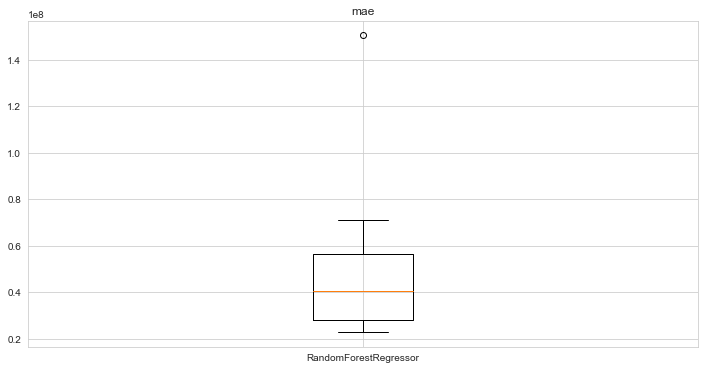

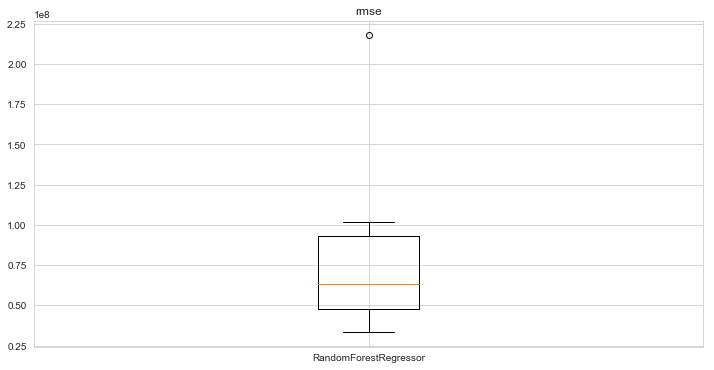

In [80]:
models = [ ('RandomForestRegressor', RandomForestRegressor(n_estimators=300, n_jobs=-1)),
           # ('Ridge Regressor', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001))
]
#('GradientBoosting', GradientBoostingRegressor()),
#('LinearRegression', LinearRegression()),
#('LassoRegressor', Lasso(alpha=0.1)),
#('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
#('DecisionTreeRegressor', DecisionTreeRegressor())
#('KNeighborsRegressor', KNeighborsRegressor(5))

#('SVMRegressor', SVR()), - Slow - check the optimal C (find the function)
#('GaussianRegressor',GaussianProcessRegressor()),
#('SGDRegressor', SGDRegressor(), - bad results, check the parameters

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train_k, X_test_k = X.values[train_index], X.values[test_index]
        y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train_k, y_train_k.ravel())
        y_pred = model.predict(X_test_k)
        mae = mean_absolute_error(y_test_k, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)
        
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train: ', X_train.shape, 'y_train:', y_train.shape, '\nX_test: ', X_test.shape, 'y_test: ', y_test.shape)
#print(X_train.head(5))
#model = LinearRegression()
model = RandomForestRegressor(500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_train:  (1596, 212) y_train: (1596,) 
X_test:  (787, 212) y_test:  (787,)


MAE 49141016.96088946


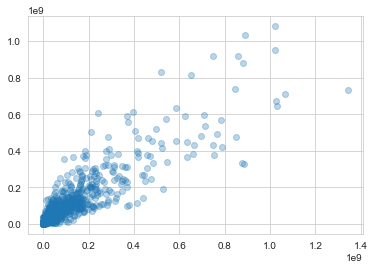

In [82]:
# Evaluate the model using the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print('MAE', mean_absolute_error(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, alpha=0.3)
plt.show()

### Feature Importances

In [83]:
print(model)
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
features = pd.DataFrame(fi).sort_values(1, ascending=False)
print(type(features))
print(features)
useless = list(features.loc[features[1] < 0.0003, 0])
print(useless)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
<class 'pandas.core.frame.DataFrame'>
                                          0    1
4                                vote_count 0.42
0                                    budget 0.42
3                                popularity 0.07
1                                      year 0.03
2                              vote_average 0.03
24                               collection 0.02
21                                 Thriller 0.00
9                                     Crime 0.00
8                                    Comedy 0.00
5                                    Action 0.00
29   Twentieth Century Fox Film Corp

### Error Analysis

In [84]:
df_new = pd.DataFrame(X_test).copy()
print(df_new.count())
print(len(y_pred))
df_new['revenue'] = y_test
df_new['prediction'] = y_pred
df_new['abs_error'] = abs(df_new['revenue']-df_new['prediction'])
df_new.sort_values(by='abs_error', ascending=False).round()
print(df_new.head())

budget                                    787
year                                      787
vote_average                              787
popularity                                787
vote_count                                787
Action                                    787
Adventure                                 787
Animation                                 787
Comedy                                    787
Crime                                     787
Documentary                               787
Drama                                     787
Family                                    787
Fantasy                                   787
Foreign                                   787
History                                   787
Horror                                    787
Music                                     787
Mystery                                   787
Romance                                   787
Science Fiction                           787
Thriller                          

In [85]:
df_error = df_new[df_new['abs_error']>1]
#df_error.groupby()
df_error.corr()['abs_error'].dropna().sort_values()

Drama                                    -0.16
Action                                   -0.14
Comedy                                   -0.13
Adventure                                -0.12
Thriller                                 -0.12
Crime                                    -0.10
Universal Pictures                       -0.10
Mystery                                  -0.09
Romance                                  -0.09
Science Fiction                          -0.08
Family                                   -0.08
Horror                                   -0.07
Paramount Pictures                       -0.07
Fantasy                                  -0.06
Warner Bros.                             -0.06
Columbia Pictures                        -0.06
Dimension Films                          -0.06
Dune Entertainment                       -0.06
Fox Searchlight Pictures                 -0.05
Relativity Media                         -0.05
Twentieth Century Fox Film Corporation   -0.05
TriStar Pictu